# Loading Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset

from torchvision import transforms
from PIL import Image

device = ('cuda' if torch.cuda.is_available() else 'cpu')

hparams = {
    'batch_size': 32,
    'use_l2_reg': True,
    'num_epochs': 20,
    'learning_rate': 0.001,
    'log_interval': 100,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

hparams['device']

'cuda'

## Define the CustomCNN

In [2]:
# Custom CNN Architecture with Batch Normalization, and Dropout options
class CustomCNN(nn.Module):
    def __init__(self, use_batch_norm=False, use_dropout=False):
        super(CustomCNN, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        # First set of convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) if self.use_batch_norm else nn.Identity()
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32) if self.use_batch_norm else nn.Identity()
        self.relu2 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25) if self.use_dropout else nn.Identity()

        # Second set of convolutional layers
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64) if self.use_batch_norm else nn.Identity()
        self.relu3 = nn.LeakyReLU()
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64) if self.use_batch_norm else nn.Identity()
        self.relu4 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25) if self.use_dropout else nn.Identity()

        # Third set of convolutional layers
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128) if self.use_batch_norm else nn.Identity()
        self.relu5 = nn.LeakyReLU()
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128) if self.use_batch_norm else nn.Identity()
        self.relu6 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25) if self.use_dropout else nn.Identity()

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Adjust the size according to your input image dimensions
        self.relu7 = nn.LeakyReLU()
        self.dropout4 = nn.Dropout(0.25) if self.use_dropout else nn.Identity()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # First set of layers
        x = self.conv1(x)
        x = self.bn1(x) if self.use_batch_norm else x
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x) if self.use_batch_norm else x
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.dropout1(x) if self.use_dropout else x

        # Second set of layers
        x = self.conv3(x)
        x = self.bn3(x) if self.use_batch_norm else x
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x) if self.use_batch_norm else x
        x = self.relu4(x)
        x = self.pool2(x)
        x = self.dropout2(x) if self.use_dropout else x

        # Third set of layers
        x = self.conv5(x)
        x = self.bn5(x) if self.use_batch_norm else x
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.bn6(x) if self.use_batch_norm else x
        x = self.relu6(x)
        x = self.pool3(x)
        x = self.dropout3(x) if self.use_dropout else x

        # Flatten the output
        x = self.flatten(x)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu7(x)
        x = self.dropout4(x) if self.use_dropout else x
        x = self.fc2(x)

        return x

## Define training and testing functions

In [3]:
def correct_predictions(predicted_batch, label_batch):
    pred = predicted_batch.argmax(dim=1, keepdim=True)
    return pred.eq(label_batch.view_as(pred)).sum().item()

def train_epoch(epoch, train_loader, network, optimizer, criterion, hparams):
    network.train()
    device = hparams['device']
    avg_loss = None
    avg_weight = 0.1
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if avg_loss:
            avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
        else:
            avg_loss = loss.item()
        if batch_idx % hparams['log_interval'] == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    return avg_loss

def test_epoch(test_loader, network, hparams):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            acc += correct_predictions(output, target)
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {acc}/{len(test_loader.dataset)} ({test_acc:.0f}%)\n')
    return test_loss, test_acc

def plot_and_save_results(tr_losses, te_losses, te_accs, experiment_num):
    # Plotting Training and Testing Losses
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(tr_losses, label='Training Loss', color='blue')
    plt.plot(te_losses, label='Testing Loss', color='red')
    plt.title(f'Training and Testing Loss Over Epochs - Experiment {experiment_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Testing Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(te_accs, label='Testing Accuracy', color='green')
    plt.title(f'Testing Accuracy Over Epochs - Experiment {experiment_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    # Save the figure
    plt.savefig(f"transfer_{experiment_num}_results.png")

    # Show the plot
    plt.show()
    
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    
    print('-------------------------------------------------------------------\n')
    print(f'{(model)}\n')
    print('-------------------------------------------------------------------\n')
    print(f'Total parameters in the model: {total_params}\n')
    print(f'Trainable parameters in the model: {trainable_params}\n')
    print(f'NON-Trainable parameters in the model: {non_trainable_params}\n')
    print('-------------------------------------------------------------------\n')
    
    return total_params, trainable_params, non_trainable_params

# Function to run an experiment
def run_training(trainloader, testloader, networkz, experiment_num=1, batch_size=hparams['batch_size'], use_l2_reg=False):
    # Update hyperparameters based on the experiment
    optimizer_weight_decay = 0.001 if use_l2_reg else 0
    
    networkz.to(device)
    
    # Calculate the total number of trainable parameters
    total_params = count_parameters(networkz)
    print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

    # Define the optimizer with or without L2 regularization
    optimizer = optim.Adam(networkz.parameters(), lr=hparams['learning_rate'], weight_decay=optimizer_weight_decay)
    
    # Define the criterion
    criterion = nn.CrossEntropyLoss()

    # Training and validation loop
    tr_losses, te_losses, te_accs = [], [], []
    
    # Start the timer
    start_time = time.time()

    for epoch in range(1, hparams['num_epochs'] + 1):
        tr_losses.append(train_epoch(epoch, trainloader, networkz, optimizer, criterion, hparams))
        te_loss, te_acc = test_epoch(testloader, networkz, hparams)
        te_losses.append(te_loss)
        te_accs.append(te_acc)
    
    # Stop the timer
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Convert elapsed time to minutes and seconds
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time % 60)

    print(f'Total Training Time: {elapsed_mins}m {elapsed_secs}s')
    
    plot_and_save_results(tr_losses, te_losses, te_accs, experiment_num)

    return networkz


## Load Terrassa 900 dataset

In [4]:
class TerrassaDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.data = self._load_data()
        self.class_to_idx = self._get_class_to_idx()

    def _load_data(self):
        data = []
        annotation_file_path = os.path.join(self.root_dir, self.split, 'annotation.txt')

        with open(annotation_file_path, 'r') as f:
            lines = f.readlines()
            for line in lines[1:]:
                image_id, class_name = line.strip().split()
                image_path = os.path.join(self.root_dir, self.split, 'images', f'{image_id}.jpg')
                data.append((image_path, class_name))

        return data

    def _get_class_to_idx(self):
        classes = set([item[1] for item in self.data])
        class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}
        return class_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, class_name = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.class_to_idx[class_name])
        return image, label
    
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
dataset_root = os.path.join(parent_dir, 'terrassa')

#ImageNet mean and std used for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
#mean = [0.5,0.5,0.5]
#std = [0.5,0.5,0.5]


# Define transform to our net
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])


# Create train and test datasets
train_dataset = TerrassaDataset(root_dir=dataset_root, split='train', transform=transform)
test_dataset = TerrassaDataset(root_dir=dataset_root, split='test', transform=transform)
val_dataset = TerrassaDataset(root_dir=dataset_root, split='val', transform=transform)

# Concatenate the original trainset with the augmented dataset (70% of all data)
combined_trainset = ConcatDataset([train_dataset, val_dataset])


# Create data loaders
terrassa_train_loader = DataLoader(combined_trainset, batch_size=hparams['batch_size'], shuffle=True)
terrassa_test_loader = DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False)


In [5]:
# Accessing a sample
sample_image, sample_label = combined_trainset[1]
print(f"Image shape: {sample_image.shape}, Label: {sample_label}")


Image shape: torch.Size([3, 32, 32]), Label: 4


torch.Size([32, 3, 32, 32]) torch.Size([32])


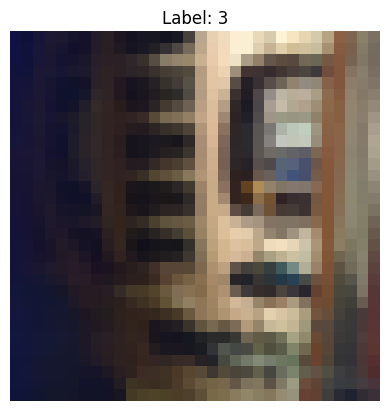

In [6]:
for images, labels in terrassa_train_loader:
  print(images.size(), labels.size())
  break
    
# Get a batch of data
data_iter = iter(terrassa_train_loader)
images, labels = next(data_iter)

# Transformation for visualization (undo normalization)
inv_normalize = transforms.Normalize(
    mean=[-mean[0] / std[0], -mean[1] / std[1], -mean[2] / std[2]],
    std=[1 / std[0], 1 / std[1], 1 / std[2]]
)


# Function to display an image
def show_image(img, title):
    img = inv_normalize(img)
    img = torch.clamp(img, 0, 1)  # Clip values to stay within valid range
    plt.imshow(img.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display the first image from the batch
show_image(images[0], title=f"Label: {labels[0]}")

# 1. Custom CNN over Terrassa 900

In [7]:
network = CustomCNN(use_batch_norm=True, use_dropout=True)

# Define a new output layer with 13 classes
output_terrassa = nn.Linear(in_features=network.fc2.in_features, out_features=13)

network.fc2 = output_terrassa

#network = run_training(terrassa_train_loader, terrassa_test_loader, network, batch_size=hparams['batch_size'], use_l2_reg=hparams['use_l2_reg'])


# 1.5 Custom CNN over Terrassa 900 (transferred parameters from Cifar10 Custom)

In [8]:
#best Custom CNN from Cifar10 training
network = CustomCNN(use_batch_norm=True, use_dropout=True)
model_path = "custom_cnn_model_best_task2.pth"
network.load_state_dict(torch.load(model_path, map_location=device))


# Define a new output layer with 13 classes
output_terrassa = nn.Linear(in_features=network.fc2.in_features, out_features=13)

network.fc2 = output_terrassa

#network = run_training(terrassa_train_loader, terrassa_test_loader, network, batch_size=hparams['batch_size'], use_l2_reg=hparams['use_l2_reg'])


# 2. Custom CNN on CIFAR10 as a feature extractor for Terrassa 900

### Load custom_cnn_model_best_task2 model weights from Task 2 (84% accuracy on Cifar10)

In [9]:
network = CustomCNN(use_batch_norm=True, use_dropout=True)
model_path = "custom_cnn_model_best_task2.pth"
network.load_state_dict(torch.load(model_path, map_location=device))

print(network)

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel

### Freeze all layers and put new Linear output layer for Terrassa, trainable

In [10]:

for param in network.parameters():
    param.requires_grad = False
    
# Define a new output layer with 13 classes
output_terrassa = nn.Linear(in_features=network.fc2.in_features, out_features=13)

network.fc2 = output_terrassa
for param in network.fc2.parameters():
    param.requires_grad = True


In [11]:
#network = run_training(terrassa_train_loader, terrassa_test_loader, network, batch_size=hparams['batch_size'], use_l2_reg=hparams['use_l2_reg'])

# 3. Fine tuning on vgg16, 1/3 frozen layers and new layers

### Load vgg16 

In [12]:
# Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

print(vgg16)

C:\Users\pauco\miniconda3\envs\py311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\pauco\miniconda3\envs\py311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Terrassa loader for vgg16 size

In [13]:
# Define transform to our net
transform2 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])


# Create train and test datasets
train_dataset_vgg = TerrassaDataset(root_dir=dataset_root, split='train', transform=transform2)
test_dataset_vgg = TerrassaDataset(root_dir=dataset_root, split='test', transform=transform2)
val_dataset_vgg = TerrassaDataset(root_dir=dataset_root, split='val', transform=transform2)

# Concatenate the original trainset with the augmented dataset (70% of all data)
combined_trainset_vgg = ConcatDataset([train_dataset_vgg, val_dataset_vgg])


# Create data loaders
terrassa_train_loader_vgg = DataLoader(combined_trainset_vgg, batch_size=hparams['batch_size'], shuffle=True)
terrassa_test_loader_vgg = DataLoader(test_dataset_vgg, batch_size=hparams['batch_size'], shuffle=False)

### Freeze the layers closer to the input layer, replace last layers (classifier) with new layers

In [14]:
# Modify and extend the classifier

for i in range(0,11):
    vgg16.features[i].requires_grad = False

vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 2048),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(1024, 13)
)

for param in vgg16.classifier.parameters():
    param.requires_grad = True
    

In [15]:
vgg16.features[0].requires_grad

False

In [16]:
#network = run_training(terrassa_train_loader_vgg, terrassa_test_loader_vgg, vgg16, batch_size=hparams['batch_size'], use_l2_reg=hparams['use_l2_reg'])

# 4. More fine tuning with ParisComas dataset

## Load ParisComas dataset

In [17]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class ParisComasDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = self._make_dataset()

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def _make_dataset(self):
        images = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_path):
                for image_name in os.listdir(class_path):
                    image_path = os.path.join(class_path, image_name)
                    images.append((image_path, self.class_to_idx[class_name]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path, label = self.images[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
dataset_root = os.path.join(parent_dir, 'paris')

paris_dataset = ParisComasDataset( dataset_root)

# Accessing a sample
sample_image, sample_label = paris_dataset[1]
print(f"Image shape: {sample_image.shape}, Label: {sample_label}")


Image shape: torch.Size([3, 224, 224]), Label: 0


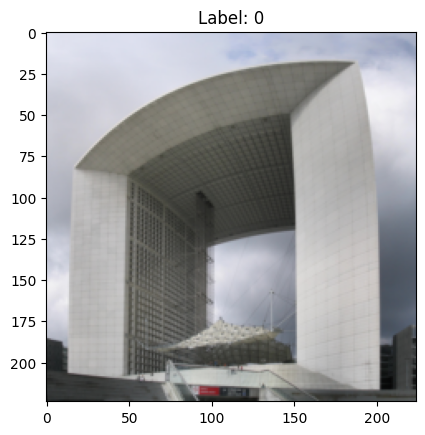

SyntaxError: 'break' outside loop (684855907.py, line 6)

In [18]:
# Display the image and label
plt.imshow(sample_image.permute(1, 2, 0))
plt.title(f"Label: {sample_label}")
plt.axis('on')  # Hide axes
plt.show()
#break  # Only display the first image for simplicity

In [19]:
#Change labels so they go from 13+
for i in range(len(paris_dataset)):
    _, label = paris_dataset[i]
    paris_dataset.images[i] = (paris_dataset.images[i][0], torch.tensor(label + 13))


### Join Terrassa and ParisComas dataset

In [20]:
# Concatenate the original trainset with the augmented dataset (70% of all data)
combined_trainset_vgg_terrassa_paris = ConcatDataset([train_dataset_vgg, val_dataset_vgg, paris_dataset])


# Create data loaders
terrassa_train_loader_vgg_terrassa_paris = DataLoader(combined_trainset_vgg_terrassa_paris, batch_size=hparams['batch_size'], shuffle=True)
terrassa_test_loader_vgg_terrassa_paris = DataLoader(test_dataset_vgg, batch_size=hparams['batch_size'], shuffle=False)

In [26]:
vgg16_2.features[9]

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

### Adapt VGG for the 13+9 classes

-------------------------------------------------------------------

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=Tru

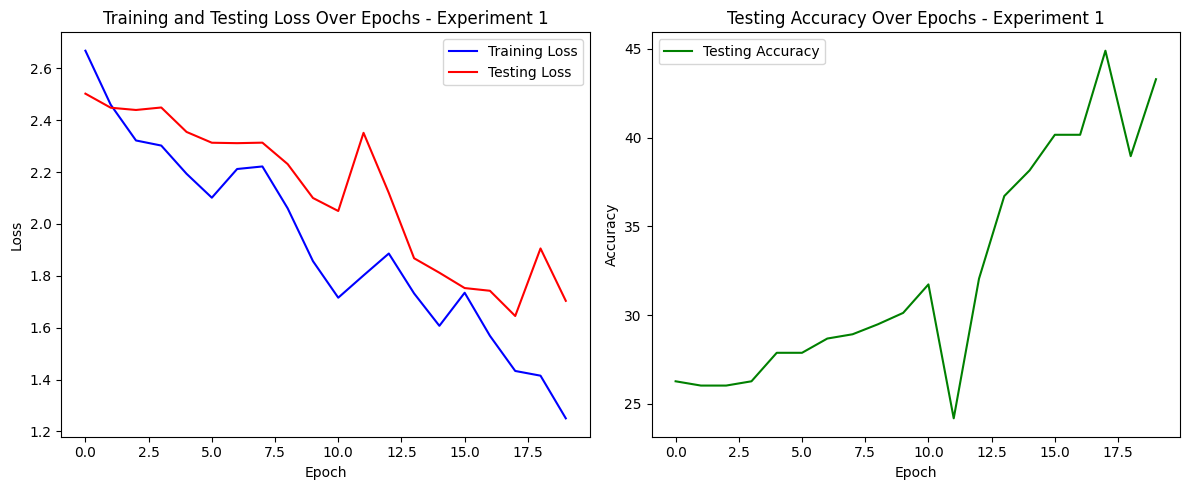

In [21]:
vgg16_2 = models.vgg16(pretrained=True)

for param in vgg16_2.parameters():
    param.requires_grad = True
    
for i in range(0,11):
    vgg16_2.features[i].requires_grad = False

    
vgg16_2.classifier = nn.Sequential(
    nn.Linear(25088, 2048),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(1024, 22)
)   

network = run_training(terrassa_train_loader_vgg_terrassa_paris, terrassa_test_loader_vgg_terrassa_paris, vgg16_2, batch_size=hparams['batch_size'], use_l2_reg=hparams['use_l2_reg'])